# EDA - влияние условий жизни нa успеваемость по математике.

Импортируем нужные для чтения и первичного анализа библиотеки и прочитаем файл.

In [663]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import numpy as np

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
students = pd.read_csv('stud_math.csv')

params = {'figure.constrained_layout.use': False,
          'axes.facecolor': 'gainsboro',
          'axes.grid': True,
          'grid.linestyle': '--',
          'axes.labelsize': 16,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)
%matplotlib inline

## Содержание

1. [Предобработка](#1)
1. [Первичный отсмотр данных](#2)
2. [Первичный анализ данных в строковых стобцах](#3)
3. [Корреляционный анализ](#4)
4. [Анализ номинативных переменных](#5)
5. [Выводы](#6)

***

## 1. Предобработка<a name="1"></a>

In [664]:
students.columns = [col.lower() for col in students.columns]

In [665]:
def get_countplot(tpl):
    '''Функция для строковых столбцов.

    Позволяет, как выводить единичный график,
    так и несколько графиков в отдельных полях.
    '''
    fig = plt.figure(figsize=(20 if len(tpl) > 1 else 12,
                              7*((len(tpl)//3)+1)), dpi=80)
    gs = fig.add_gridspec((len(tpl)//3)+1,
                          len(tpl) if len(tpl) <= 3 else 3)
    for i in range(len(tpl)):
        ax = fig.add_subplot(gs[i//3, i % 3])
        col = students[tpl[i]].value_counts(ascending=True)
        # Проверка на пропуски
        pct_missing = round(np.mean(students[tpl[i]].isnull())*100, 2)
        max_value = col.max()

        sns.countplot(x=tpl[i],
                      data=students,
                      order=col.index,
                      palette='Blues',
                      edgecolor='k',
                      linewidth=2)
        ax.set_title(f'Распределения признака {tpl[i]}')
        ax.set_ylim(0, max_value+max_value*0.2)
        ax.set_ylabel('Количество')
        for i, value in enumerate(col.values):
            ax.text(i, value+0.5, value,
                    horizontalalignment='center',
                    fontsize=14,
                    bbox={'facecolor': 'w'})
        ax.text(0, max_value+max_value*0.1,
                f'Процент пропусков: {pct_missing}%',
                fontsize=16, bbox={'facecolor': 'w'})

In [666]:
def get_histogram(tpl):
    '''Функция для числовых столбцов.'''
    fig = plt.figure(figsize=(20 if len(tpl) > 1 else 12,
                              7*((len(tpl)//2)+1)), dpi=80)
    gs = fig.add_gridspec((len(tpl)//2)+1,
                          len(tpl) if len(tpl) <= 2 else 2)
    for i in range(len(tpl)):
        ax = fig.add_subplot(gs[i//2, i % 2])
        col = students[tpl[i]]
        counts, bins = np.histogram(col.dropna())
        pct_missing = round(np.mean(col.isnull())*100, 2)

        ax.hist(bins[:-1], bins,
                weights=counts,
                color='steelblue',
                edgecolor='k',
                linewidth=2)
        ax.set_title(f'Распределения признака {tpl[i]}')
        ax.set_ylim(0, max(counts)+max(counts)*0.15)
        ax.axvline(col.median(), color='w',
                   linestyle='--', linewidth=3)
        ax.axvline(col.mean(), color='k',
                   linestyle='--', linewidth=3)
        ax.text(col.mean()*1.01, max(counts)*0.9,
                f'Mean: {round(col.mean(), 2)}',
                fontsize=14, bbox={'facecolor': 'w'})
        ax.text(col.median()*1.01, max(counts)*0.8,
                f'Median: {round(col.median(), 2)}',
                fontsize=14, bbox={'facecolor': 'w'})
        ax.text(col.min(), max(counts)+max(counts)*0.06,
                f'Процент пропусков: {pct_missing}%',
                fontsize=16, bbox={'facecolor': 'w'})

In [667]:
def first_look(*args):
    if type(args[0]) == list:
        args = args[0]

    if students[args[0]].dtype == 'O':
        return get_countplot(args)
    else:
        return get_histogram(args)

In [668]:
def iqr_filter(column):
    perc25 = students[column].quantile(0.25)
    perc75 = students[column].quantile(0.75)
    IQR = perc75 - perc25
    print('25-й перцентиль:', perc25)
    print('75-й перцентиль:', perc75)
    print('IQR:', IQR)

    return students.loc[~students[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)][[column, 'score']].sort_values([column]).dropna()

In [669]:
def fill_missing(*args):
    if type(args[0]) == list:
        args = args[0]

    for i in range(len(args)):
        score_counts = students.groupby(
            ['score'])[args[i]].value_counts().unstack().T
        if args[i] == 'fjob':
            students[args[i]] = students[[args[i], 'score']].apply(
                lambda x: students[args[i]].mode()[0] if
                x[1] == 100 or x[1] == 20 else x[0], axis=1)
        students[args[i]] = students[[args[i], 'score']].apply(
            lambda x: score_counts[x[1]].idxmax() if
            pd.isna(x[0]) else x[0], axis=1)
        print(f'Пропуски в столбце {args[i]} заполнены')

In [670]:
def get_jointplot(x, y):
    corr = round(students[[x, y]].corr().values[0][1], 2)
    sns.jointplot(x=x, y=y, data=students, kind='reg')
    print(f'Корреляция: {corr}')

In [696]:
def add_n_obs(df, group_col, y):
    medians_dict = {grp[0]: grp[1][y].median()
                    for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    counts = df.groupby(group_col)[y].size().values
    for (x, xticklabel), count in zip(enumerate(xticklabels), counts):
        plt.text(x, medians_dict[xticklabel]*1.04, str(n_ob),
                 horizontalalignment='center',
                 fontsize=14,
                 bbox={'facecolor': 'w'})

In [672]:
def get_stat_dif(column):
    cols = students[column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students[column] == comb[0], 'score'],
                     students.loc[students[column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            return 'ttest: значимые различия'
            break

In [673]:
def get_anova(column):
    values = students[column].value_counts().index
    values_arrays = []
    for value in values:
        values_arrays.append(students.loc[students[column] == value, 'score'])
    if f_oneway(*values_arrays).pvalue <= 0.05:
        return 'ANOVA: значимые различия'

In [674]:
def get_boxplot(*args):
    '''Функция позволяет, как выводить единичный график,
       так и несколько графиков в оотдельных полях'''
    if type(args[0]) == list:
        args = args[0]

    fig = plt.figure(figsize=(20 if len(args) > 1 else 12,
                              7*((len(args)//3)+1)), dpi=80)
    gs = fig.add_gridspec((len(args)//3)+1, len(args) if len(args) <= 3 else 3)
    for i in range(len(args)):
        ax = fig.add_subplot(gs[i//3, i % 3])

        sns.boxplot(x=args[i], y='score',
                    data=students, palette='Blues')
        ax.set_title('Формы распределения для ' + args[i])
        ax.set_ylim(0, 120)
        add_n_obs(students, args[i], 'score')
        ax.text(0, 110, get_stat_dif(args[i]),
                fontsize=16, bbox={'facecolor': 'w'})
        ax.text(0, 10, get_anova(args[i]),
                fontsize=16, bbox={'facecolor': 'w'})

***

## 2. Первичный отсмотр данных<a name="2"></a>

In [675]:
display(students.tail(5))
students.info()

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,NaN,father,1.0,1.0,0.0,NaN,no,no,no,yes,-3.0,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    float64
 7   fedu                 371 non-null    float64
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В датасете 395 строк, 30 стобцов, из них 13 - числовые, 17 - строковые. В большинстве столбцов присутствуют пустые значения, но их количество не критичное. В дальнейшем решим, как заполнить пропуски. Так как по заданию __score__ - предсказываемая величина, сразу удалим строки с пропусками в это столбце:

In [676]:
students = students[students['score'].notnull()]

***

## 3. Первичный анализ данных в стобцах<a name="3"></a>

In [677]:
students.describe()

,age,medu,fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,389.000000,386.000000,365.000000,361.000000,382.000000,367.000000,382.000000,362.000000,380.000000,382.000000,374.000000,378.000000,389.000000
mean,16.673522,2.766839,2.627397,1.434903,2.036649,0.326975,-6.109948,3.930939,3.223684,3.094241,3.529412,7.320106,52.262211
std,1.265662,1.094277,2.241790,0.692660,0.847239,0.729479,2.541716,0.931554,0.993364,1.116104,1.402006,23.615525,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [678]:
students.describe(include='O')

,school,sex,address,famsize,pstatus,mjob,fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,389,389,374,362,344,370,353,372,358,380,351,350,375,374,369,355,358
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,344,204,291,255,308,127,194,135,248,331,216,197,192,297,350,300,235


На первый взгляд данные достаточно чистые. В столбце __absences__ наблюдается экстремальное максимальное значение. Также в столбцах __Fedu__ и __famrel__ наблюдаются данные, отличные от значений указанных в информации к датасету. В строковых столбцах не больше пяти уникальных значений.

Для начала посмотрим на предсказываемую переменную __score__:

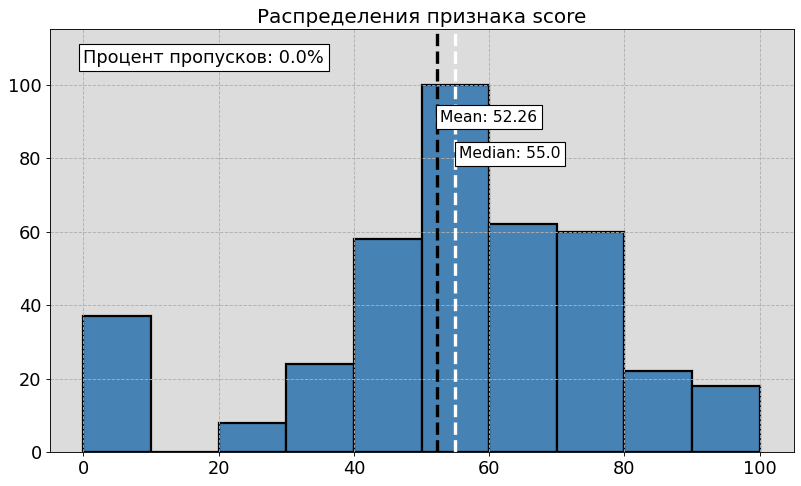

In [679]:
first_look('score')

Бросается в глаза большое количество оценок близких к нулю в столбце __score__. Посмотрим внимательнее:

In [680]:
students['score'].value_counts().sort_index()

0.0      37
20.0      1
25.0      7
30.0     15
35.0      9
40.0     31
45.0     27
50.0     54
55.0     46
60.0     31
65.0     31
70.0     27
75.0     33
80.0     16
85.0      6
90.0     12
95.0      5
100.0     1
Name: score, dtype: int64

Нули явно выходят за рамки нормального распределения и их можно считать выбросами. Так как __score__ - предсказываемая величина, лучше удалим их:

In [681]:
students = students[students['score'] != 0]

Теперь посмотрим на остальные столбцы:

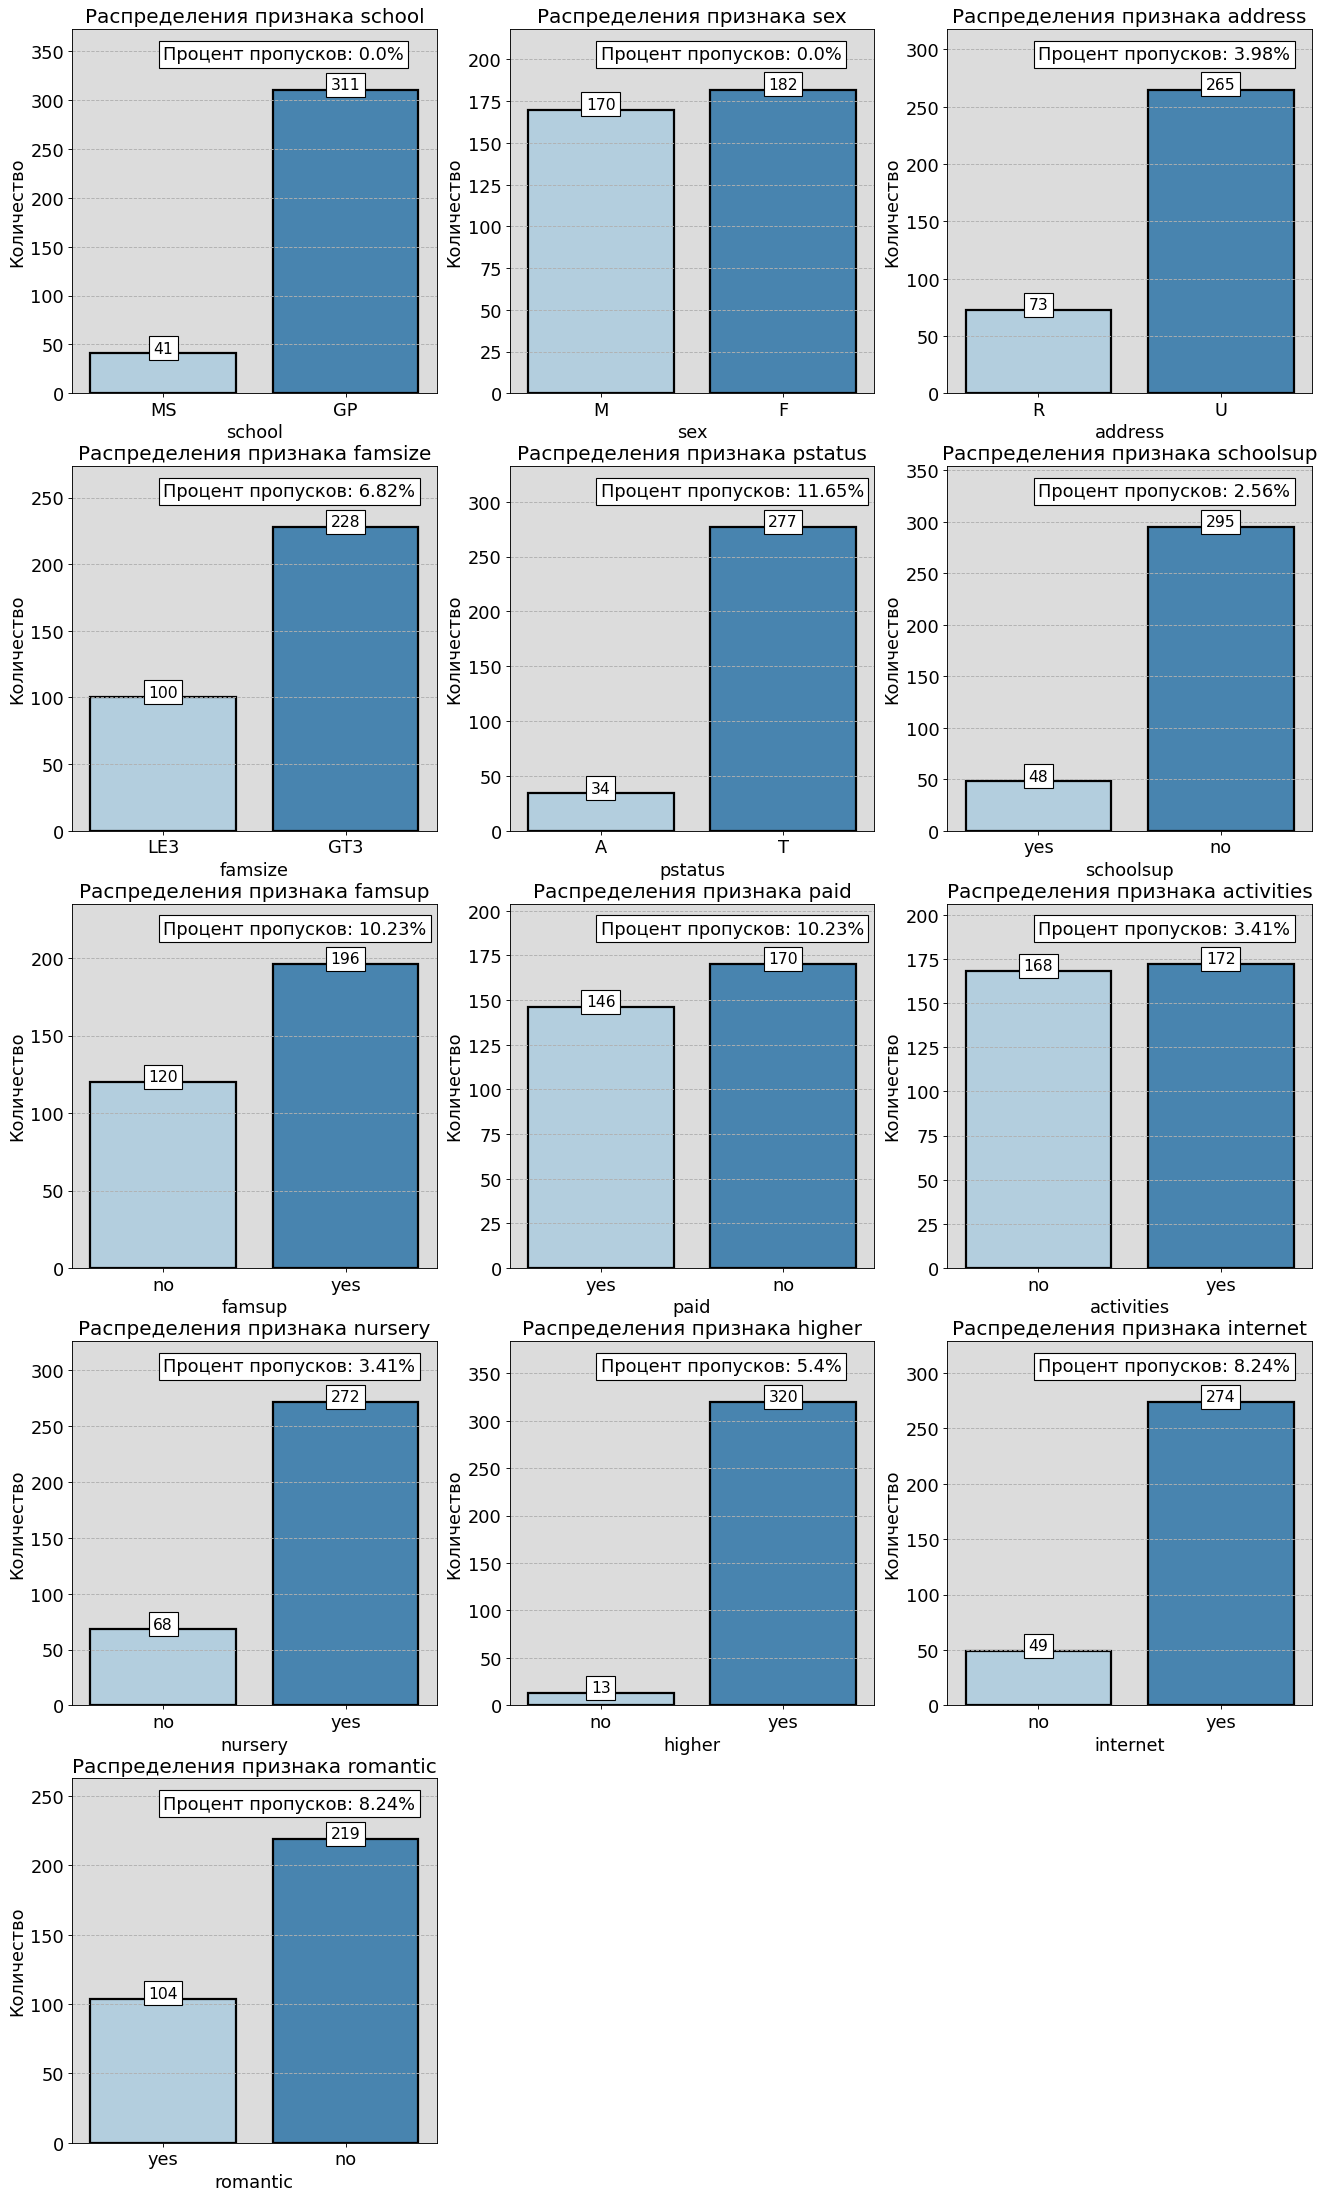

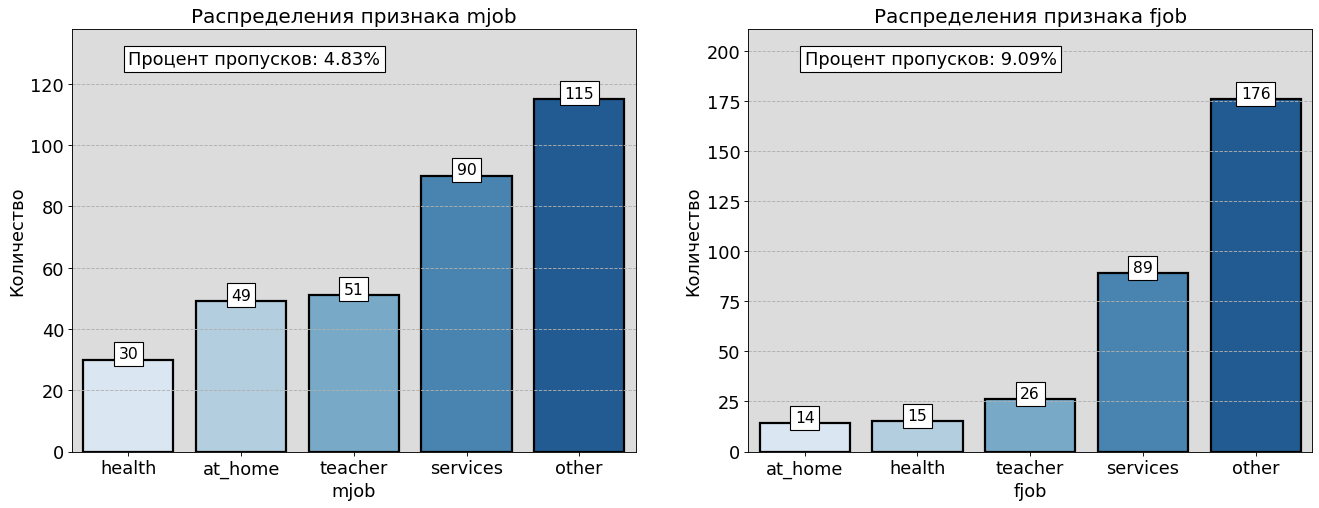

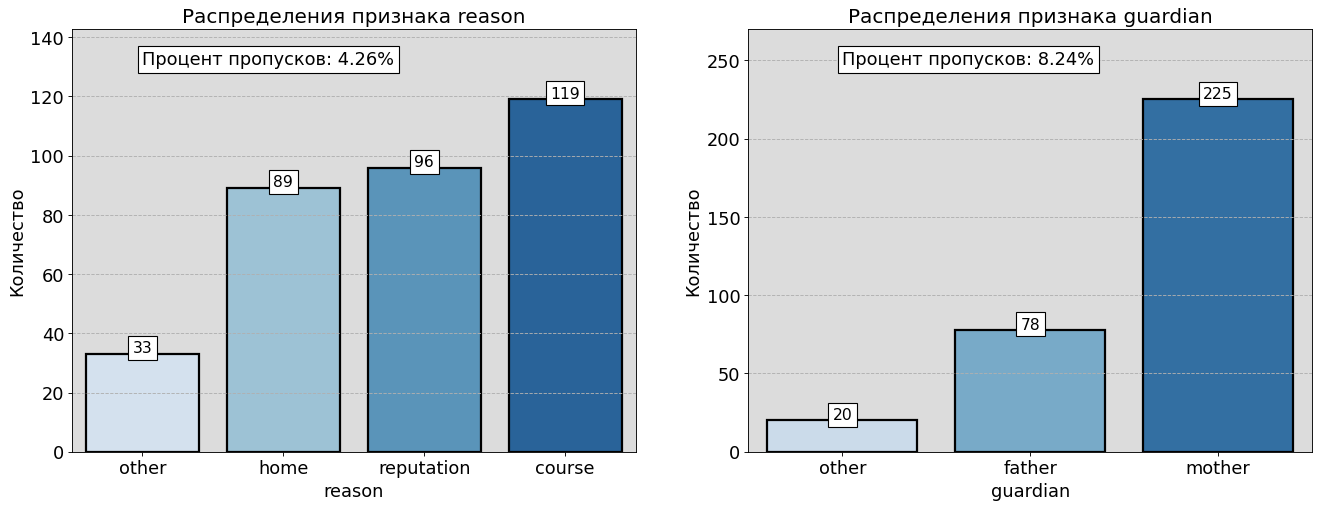

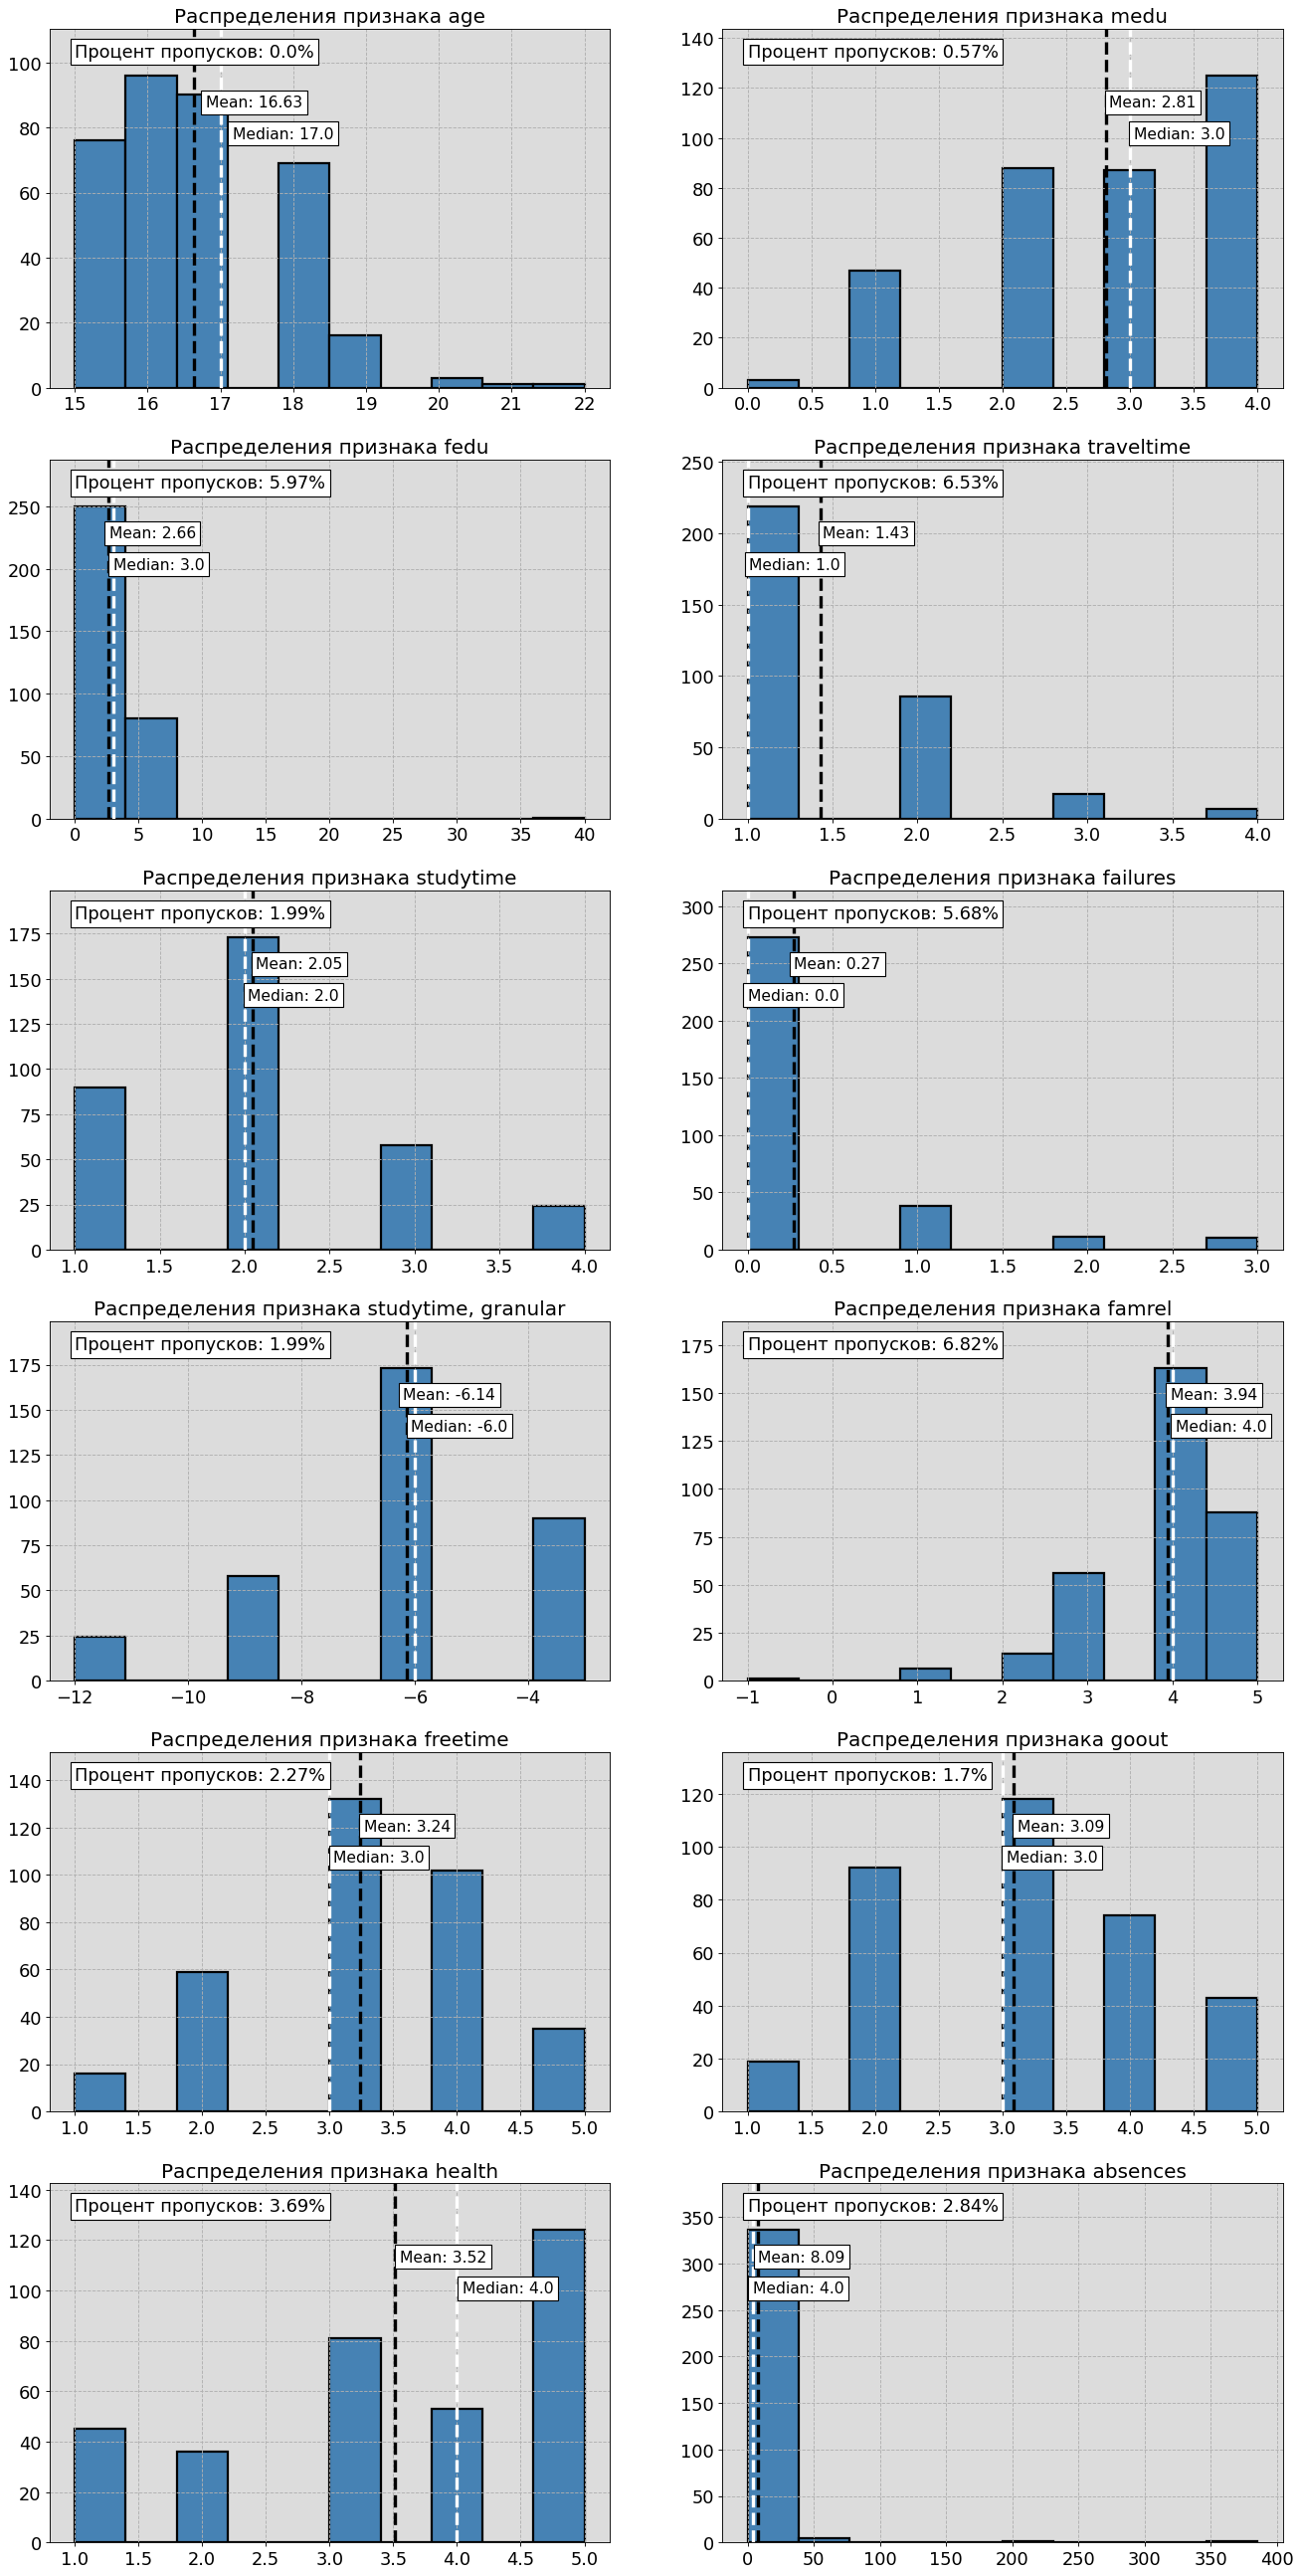

In [682]:
first_look([col for col in students.columns if
            students[col].nunique() == 2 and
            students[col].dtype == 'O'])
first_look([col for col in students.columns if
            students[col].nunique() == 5 and
            students[col].dtype == 'O'])
first_look([col for col in students.columns if
            students[col].nunique() == 3 or
            students[col].nunique() == 4 and
            students[col].dtype == 'O'])
first_look([col for col in students.columns if
            students[col].name != 'score' and
            students[col].dtype != 'O'])

Судя по графикам столбцы __studytime__ и __studytime, granular__ зеркальны по отношению друг к другу. Проверим это:

Корреляция: -1.0


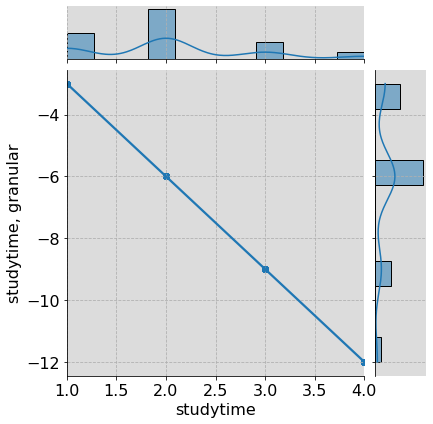

In [683]:
get_jointplot('studytime', 'studytime, granular')

In [684]:
students.drop('studytime, granular', axis=1, inplace=True)

In [685]:
students['fedu'].value_counts().sort_index()

0.0      2
1.0     65
2.0     94
3.0     89
4.0     80
40.0     1
Name: fedu, dtype: int64

In [686]:
students.loc[students['fedu'] == 40, 'fedu'] = 4

In [687]:
students['famrel'].value_counts().sort_index()

-1.0      1
 1.0      6
 2.0     14
 3.0     56
 4.0    163
 5.0     88
Name: famrel, dtype: int64

In [688]:
students.loc[students['famrel'] == -1, 'famrel'] = 1

In [689]:
iqr_filter('absences')

25-й перцентиль: 2.0
75-й перцентиль: 8.0
IQR: 6.0


,absences,score
89,18.0,35.0
123,18.0,65.0
309,18.0,50.0
203,18.0,30.0
234,18.0,30.0
281,19.0,50.0
237,20.0,60.0
311,20.0,65.0
118,20.0,40.0
304,20.0,65.0


In [690]:
score_counts = students.groupby(
    ['score'])['absences'].value_counts().unstack().T
students['absences'] = students[['absences', 'score']].apply(
    lambda x: score_counts[x[1]].idxmax() if
    x[0] == 212 or x[0] == 385 else x[0], axis=1)

In [691]:
fill_missing(
    [col for col in students.columns if students[col].name != 'score'])

Пропуски в столбце school заполнены
Пропуски в столбце sex заполнены
Пропуски в столбце age заполнены
Пропуски в столбце address заполнены
Пропуски в столбце famsize заполнены
Пропуски в столбце pstatus заполнены
Пропуски в столбце medu заполнены
Пропуски в столбце fedu заполнены
Пропуски в столбце mjob заполнены
Пропуски в столбце fjob заполнены
Пропуски в столбце reason заполнены
Пропуски в столбце guardian заполнены
Пропуски в столбце traveltime заполнены
Пропуски в столбце studytime заполнены
Пропуски в столбце failures заполнены
Пропуски в столбце schoolsup заполнены
Пропуски в столбце famsup заполнены
Пропуски в столбце paid заполнены
Пропуски в столбце activities заполнены
Пропуски в столбце nursery заполнены
Пропуски в столбце higher заполнены
Пропуски в столбце internet заполнены
Пропуски в столбце romantic заполнены
Пропуски в столбце famrel заполнены
Пропуски в столбце freetime заполнены
Пропуски в столбце goout заполнены
Пропуски в столбце health заполнены
Пропуски в столбц

***

## 4. Корреляционный анализ<a name="4"></a>

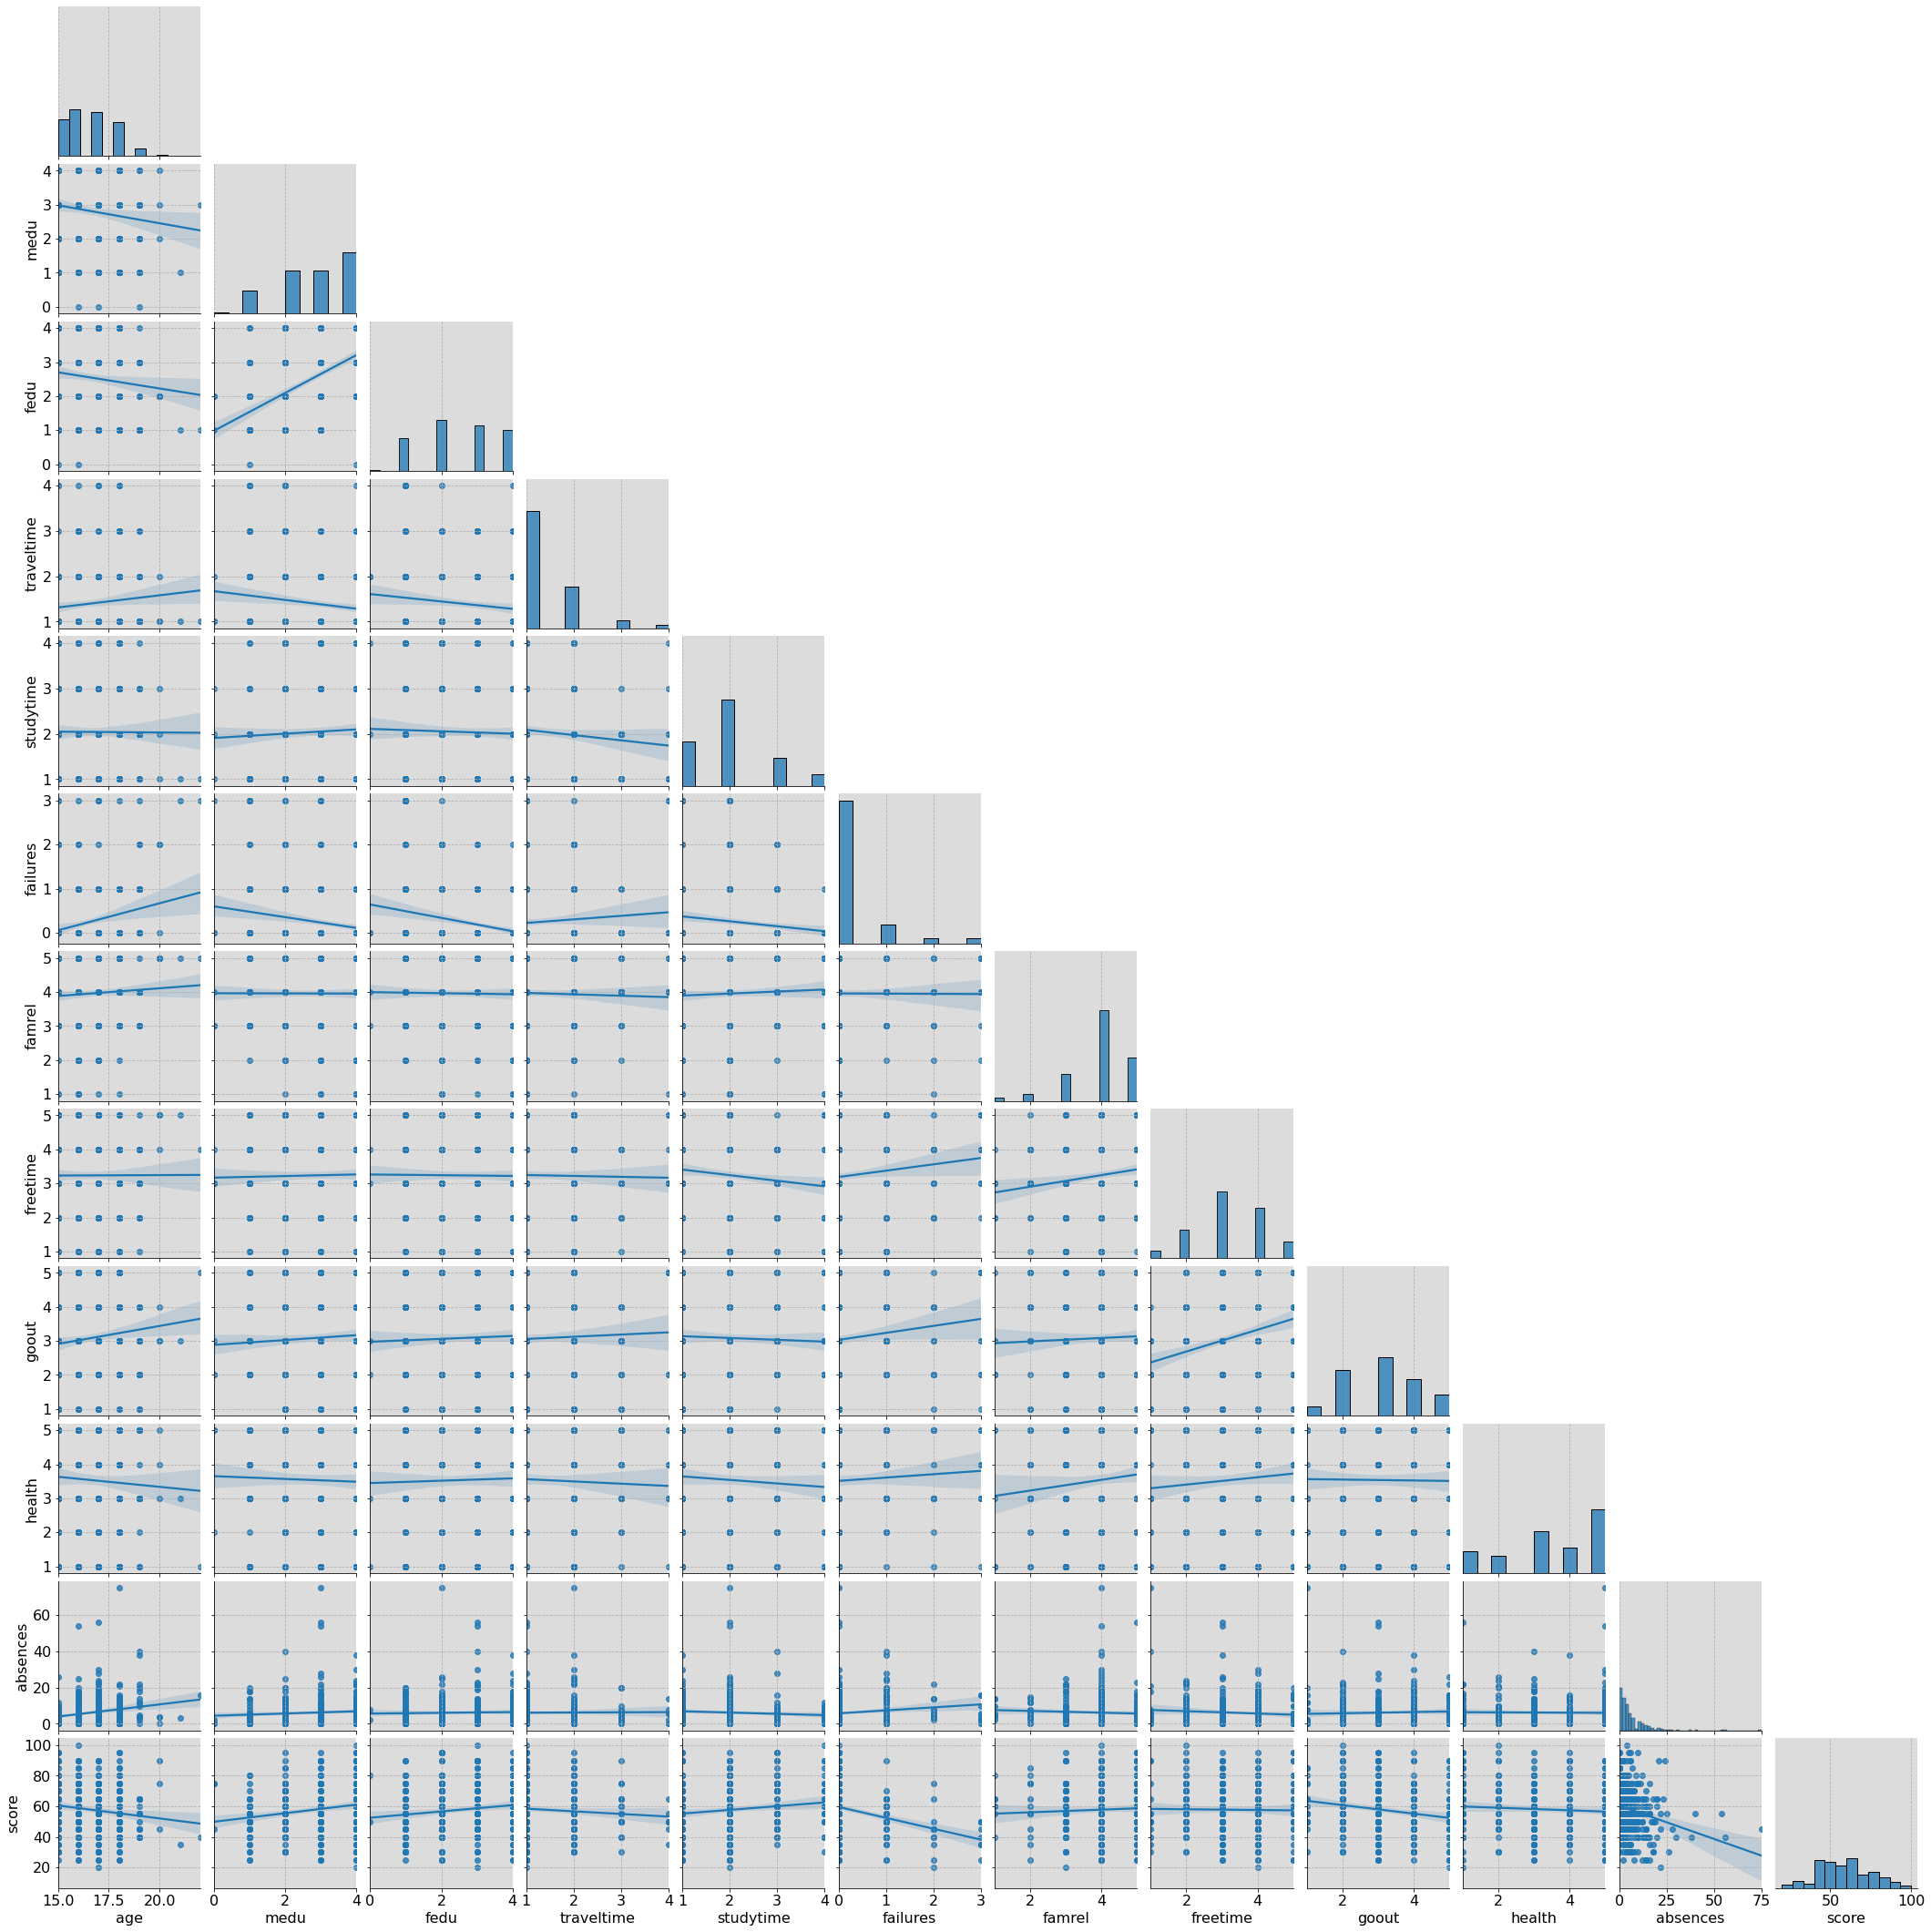

In [695]:
sns.pairplot(students, corner=True, kind='reg')

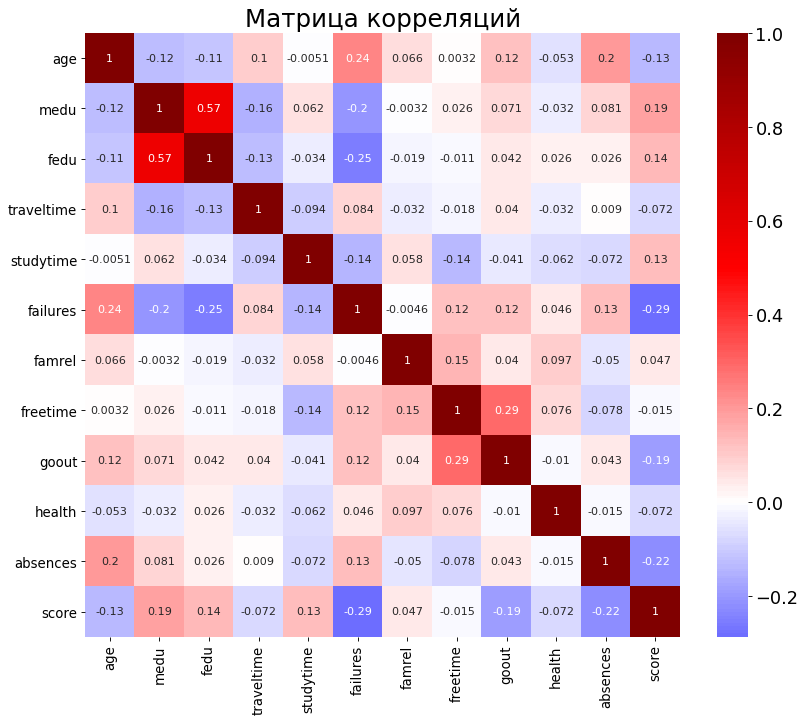

In [693]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(students.corr(), xticklabels=students.corr().columns,
            yticklabels=students.corr().columns, cmap='seismic', center=0, annot=True)

plt.title('Матрица корреляций', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

***

## 5. Анализ номинативных переменных<a name="5"></a>

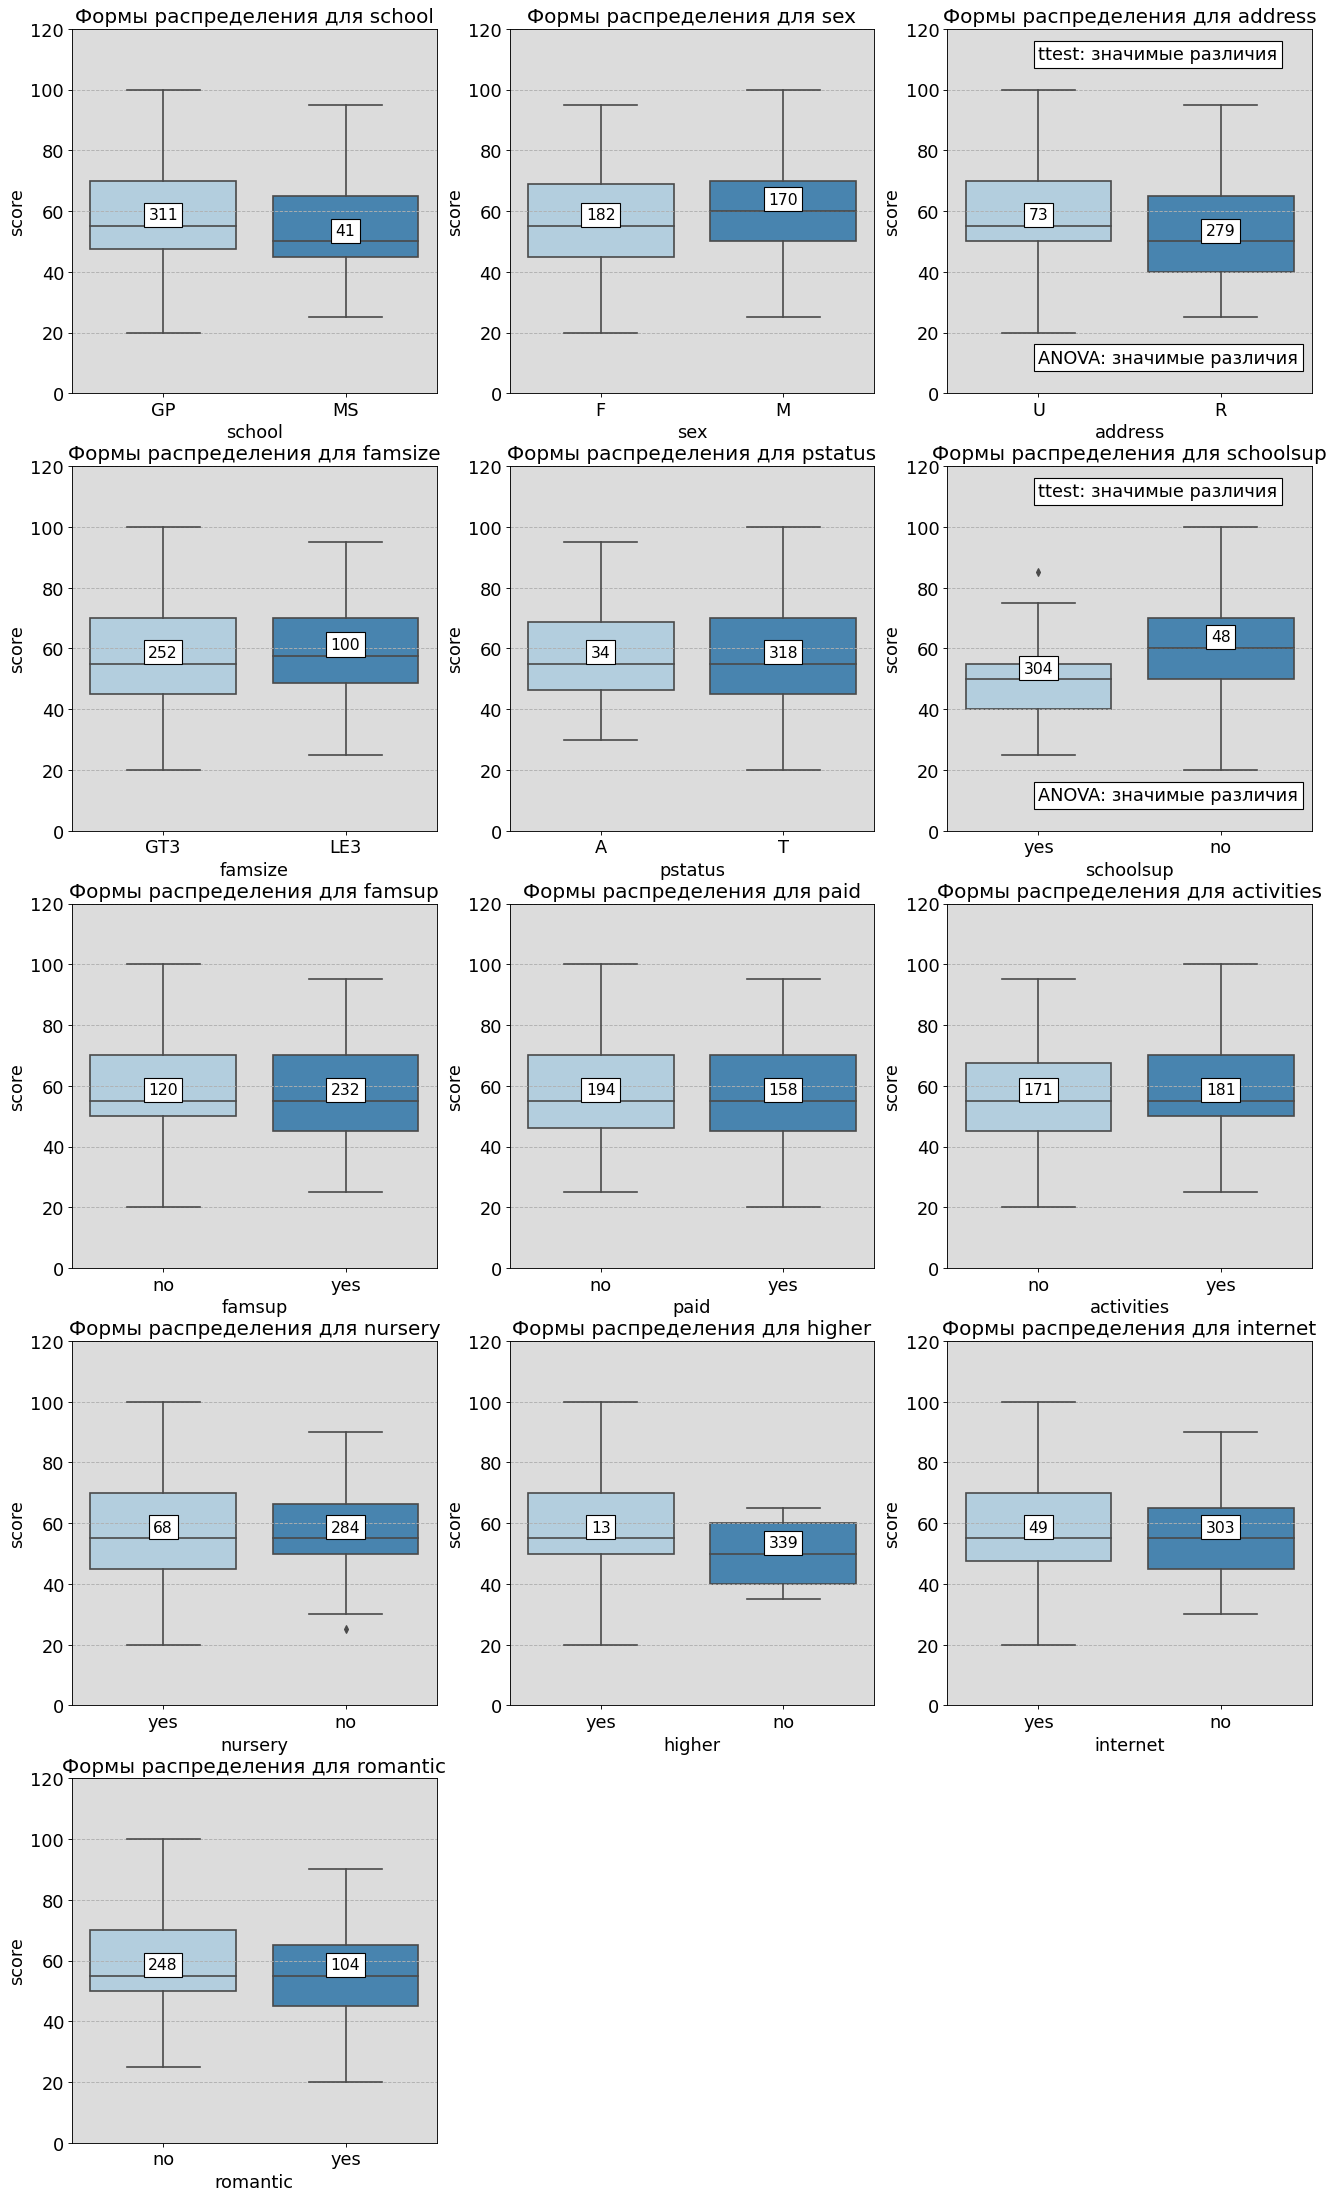

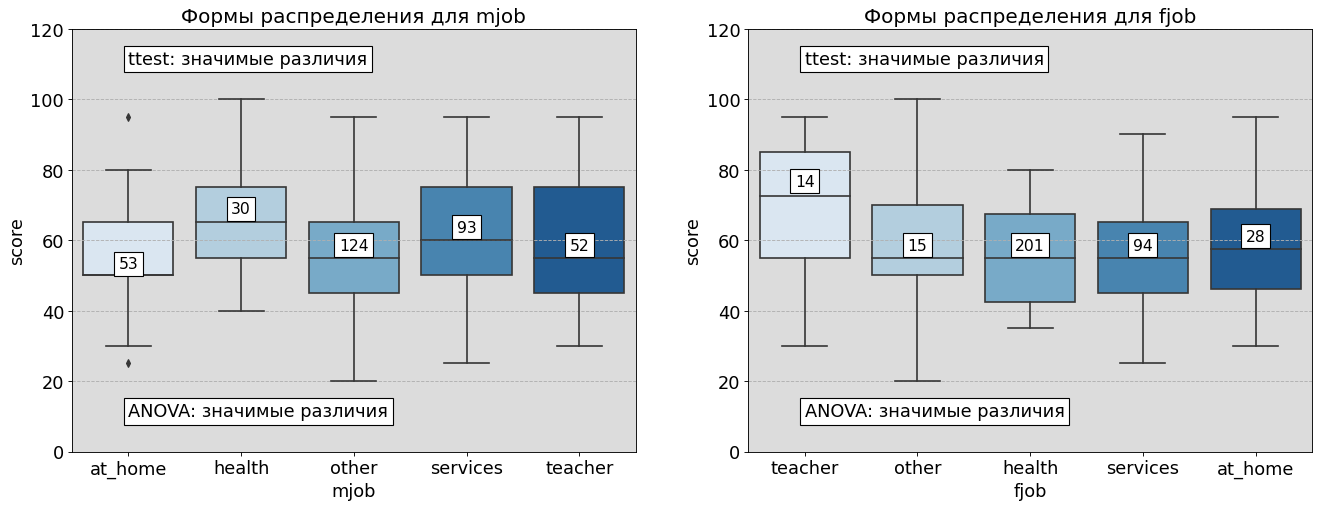

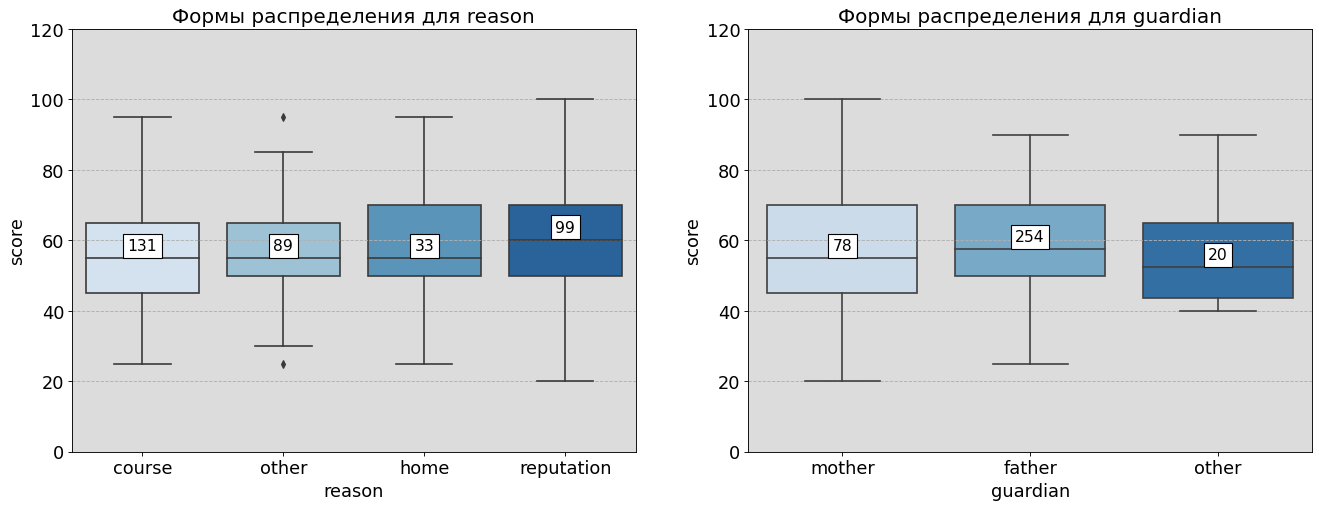

In [694]:
get_boxplot([col for col in students.columns if students[col].nunique(
) == 2 and students[col].dtype == 'O'])
get_boxplot([col for col in students.columns if students[col].nunique(
) == 5 and students[col].dtype == 'O'])
get_boxplot([col for col in students.columns if students[col].nunique(
) == 3 or students[col].nunique() == 4 and students[col].dtype == 'O'])

***

## 6. Выводы<a name="6"></a>